# Función de _ranking_ 2: BM25F

Usaremos aquí la frecuencia de términos normalizada por campos ($ftf$, de _Field dependent normalized Term Frequency_). Así, para un término $t$ dado, y un campo $f \in \{url, header, body, title, anchor\}$ en el documento $d$, usaremos:

\begin{equation}
ftf_{d,f,t} = \frac{tf_{d,f,t}}{1 + B_f((\text{len}_{d,f} / \text{avlen}_f) - 1)}
\tag{1}
\end{equation}

Donde $tf_{d,f,t}$ es la frecuencia cruda de $t$ en el campo $f$ del documento $d$, $len_{d,f}$ es la longitud del campo $f$ en $d$, y $avlen_f$ es la longitud media del mismo campo en toda la colección.

Por supuesto, las correspondientes variables $avlen_{body}$, $avlen_{url}$, $avlen_{title}$, $avlen_{header}$ y $avlen_{anchor}$ se deberán computar usando de nuevo el conjunto de _training_. Los valores de $B_f$ serán parámetros adicionales dependientes de cada uno de los campos $f$, y al igual que los $c_f$ de la sección anterior, deberán ser ajustados. Si $avlen_f$ fuese cero, entonces definiremos $ftf_{d,f,t} = 0$ (si bien esto no debería ser necesario en este _dataset_ en concreto).

El peso global para el término $t$ en el documento $d$, usando ya todos los campos, sería:

\begin{equation}
w_{d,t} = \sum_{f} W_f \cdot ftf_{d,f,t}
\tag{2}
\end{equation}

Siendo, de nuevo, los distintos $W_f$ parámetros que determinan los pesos de importancia relativos dados a cada uno de los campos.

Puesto que, además, tenemos también una característica adicional no textual (el <b>pagerank</b>), la incorporaremos también en nuestra función de _ranking_ usando el método descrito en las transparencias de teoría.

En concreto, pues, y resumiendo, el _scoring_ global para el $d$ respecto a la consulta $q$ quedará definido como:

\begin{equation}
\sum_{t \in q} \frac{w_{d,t}}{K_1 + w_{d,t}}idf_t + \lambda V_{j}(f)
\tag{3}
\end{equation}

De nuevo aquí $K_1$ es un parámetro libre, y la función $V_{j}$ podría ser cualquier de las funciones logarítmicas, de saturación o sigmoide mencionadas en las transparencias de teoría, y que en este caso fijaremos simplemente como $V_{pagerank}(pr) = log(\lambda'+pr)$.

$\lambda$ y $\lambda'$ son los dos últimos parámetros libres adicionales para este modelo.

In [1]:
# Imports necesarios
import sys
import array
import os
import timeit
import contextlib
import math
import urllib.request
import zipfile
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from collections import OrderedDict, Counter, defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Definiciones de clases del notebook anterior (P2a)
class Query:
    """Clase utilizada para almacenar una consulta."""
    def __init__(self, query):
        self.query_words = query.split(" ")

    def __iter__(self):
        for w in self.query_words:
            yield w

    def __eq__(self, other):
        if not isinstance(other, Query):
            return False
        return self.query_words == other.query_words

    def __hash__(self):
        return hash(str(self))

    def __str__(self):
        return " ".join(self.query_words)

    __repr__ = __str__

class Document:
    """Clase utilizada para almacenar información útil para un documento."""
    def __init__(self, url):
        self.url = url        # Cadena
        self.title = None     # Cadena
        self.headers = None   # [Lista de cadenas]
        self.body_hits = None # Diccionario: Término->[Lista de posiciones]
        self.body_length = 0  # Entero
        self.pagerank = 0     # Entero
        self.anchors = None   # Diccionario: Cadena->[Conteo total de ocurrencias (anchor_counts)]

    def __iter__(self):
        for u in self.url:
            yield u

    def __str__(self):
        result = [];
        NEW_LINE = "\n"
        result.append("url: "+ self.url + NEW_LINE);
        if (self.title is not None): result.append("title: " + self.title + NEW_LINE);
        if (self.headers is not None): result.append("headers: " + str(self.headers) + NEW_LINE);
        if (self.body_hits is not None): result.append("body_hits: " + str(self.body_hits) + NEW_LINE);
        if (self.body_length != 0): result.append("body_length: " + str(self.body_length) + NEW_LINE);
        if (self.pagerank != 0): result.append("pagerank: " + str(self.pagerank) + NEW_LINE);
        if (self.anchors is not None): result.append("anchors: " + str(self.anchors) + NEW_LINE);
        return " ".join(result)

    __repr__ = __str__

class Idf:
    """Construye un diccionario para poder devolver el IDF de un término."""
    def __init__(self):
        """Construcción del diccionario IDF"""
        try:
            with open("pa3-data/docs.dict", 'rb') as f:
                docs = pkl.load(f)
            self.total_doc_num = len(docs)
            print("Número total de documentos de la colección:", self.total_doc_num)

            with open("pa3-data/terms.dict", 'rb') as f:
                terms = pkl.load(f)
            self.total_term_num = len(terms)
            print("Número total de términos:", self.total_term_num)

            with open('pa3-data/BSBI.dict', 'rb') as f:
                postings_dict, termsID = pkl.load(f)

            self.idf = {}
            self.raw = {}
            for term_id, term_str in enumerate(terms.id_to_str):
                if term_id in postings_dict:
                    num_docs_with_term = postings_dict[term_id][1]
                    self.raw[term_str] = num_docs_with_term
                    self.idf[term_str] = math.log((self.total_doc_num + 1) / (num_docs_with_term + 1))
        except FileNotFoundError:
            print("¡Ficheros de diccionario de documentos / términos / índice no encontrados!")

    def get_raw(self, term):
        return self.raw.get(term, 0)

    def get_idf(self, term):
        if term in self.idf:
            return self.idf[term]
        else:
            return math.log(self.total_doc_num + 1)

def load_train_data(feature_file_name):
    """Carga los datos de entrenamiento."""
    line = None
    url = None
    anchor_text = None
    query = None
    query_dict = {}
    try:
        with open(feature_file_name, 'r', encoding = 'utf8') as f:
            for line in f:
                token_index = line.index(":")
                key = line[:token_index].strip()
                value = line[token_index + 1:].strip()
                if key == "query":
                    query = Query(value)
                    query_dict[query] = {}
                elif key == "url":
                    url = value;
                    query_dict[query][url] = Document(url);
                elif key == "title":
                    query_dict[query][url].title = str(value);
                elif key == "header":
                    if query_dict[query][url].headers is None:
                        query_dict[query][url].headers = []
                    query_dict[query][url].headers.append(value)
                elif key == "body_hits":
                    if query_dict[query][url].body_hits is None:
                        query_dict[query][url].body_hits = {}
                    temp = value.split(" ",maxsplit=1);
                    term = temp[0].strip();
                    if term not in query_dict[query][url].body_hits:
                        positions_int = []
                        query_dict[query][url].body_hits[term] = positions_int
                    else:
                        positions_int = query_dict[query][url].body_hits[term]
                    positions = temp[1].strip().split(" ")
                    for position in positions:
                        positions_int.append(int(position))
                elif key == "body_length":
                    query_dict[query][url].body_length = int(value);
                elif key == "pagerank":
                    query_dict[query][url].pagerank = int(value);
                elif key == "anchor_text":
                    anchor_text = value
                    if query_dict[query][url].anchors is None:
                        query_dict[query][url].anchors = {}
                elif key == "stanford_anchor_count":
                    query_dict[query][url].anchors[anchor_text] = int(value)
    except FileNotFoundError:
        print(f"Fichero {feature_file_name} no encontrado!")
    return query_dict

class IdMap:
    """Clase auxiliar para almacenar mapeos entre strings e identificadores numéricos de tokens."""
    
    def __init__(self):
        """Constructor de la clase IdMap."""
        self.str_to_id = {}  # Diccionario: string -> id numérico
        self.id_to_str = []  # Lista: índice = id, valor = string
        
    def __len__(self):
        """Devuelve el número de elementos en el mapeo."""
        return len(self.id_to_str)
    
    def _get_str(self, i):
        """Devuelve el string correspondiente al id numérico i.
        
        Args:
            i (int): Identificador numérico.
            
        Returns:
            str: String correspondiente al id.
        """
        return self.id_to_str[i]
    
    def _get_id(self, s):
        """Devuelve el id numérico correspondiente al string s.
        Si el string no existe, lo añade y devuelve su nuevo id.
        
        Args:
            s (str): String del que obtener su id.
            
        Returns:
            int: Identificador numérico del string.
        """
        if s not in self.str_to_id:
            # Si no existe, lo añadimos
            new_id = len(self.id_to_str)
            self.str_to_id[s] = new_id
            self.id_to_str.append(s)
            return new_id
        return self.str_to_id[s]
    
    def __getitem__(self, key):
        """Permite acceso mediante corchetes: idmap[key]
        Si key es int, devuelve el string.
        Si key es str, devuelve el id.
        
        Args:
            key: Puede ser int (devuelve string) o str (devuelve id).
            
        Returns:
            El string o id correspondiente.
        """
        if isinstance(key, int):
            return self._get_str(key)
        elif isinstance(key, str):
            return self._get_id(key)
        else:
            raise TypeError("La clave debe ser int o str")
    
    def __contains__(self, key):
        """Permite usar 'in' para verificar existencia.
        
        Args:
            key: Puede ser int o str.
            
        Returns:
            bool: True si existe, False en caso contrario.
        """
        if isinstance(key, int):
            return 0 <= key < len(self.id_to_str)
        elif isinstance(key, str):
            return key in self.str_to_id
        return False
    
    def __repr__(self):
        """Representación en string del objeto."""
        return f"IdMap(size={len(self)})"
    
class AbstractScorer:
    """ Una clase básica abstracta para un scorer.
        Implementa una funcionalidad básica de construcción de vectores de consulta y de documento.
        Tendrá que ser extendida adecuadamente por cada scorer específico.
    """
    def __init__(self, idf, query_weight_scheme=None, doc_weight_scheme=None):
        self.idf = idf
        self.TFTYPES = ["url", "title", "body_hits", "header", "anchor"]
        # Esquemas por defecto:
        self.default_query_weight_scheme = {"tf": 'n', "df": 'n', "norm": None} # Esquema natural, no, none
        self.default_doc_weight_scheme = {"tf": 'n', "df": 'n', "norm": None}   # Esquema natural, no, none
        self.query_weight_scheme = query_weight_scheme if query_weight_scheme is not None \
                                   else self.default_query_weight_scheme
        self.doc_weight_scheme = doc_weight_scheme if doc_weight_scheme is not None \
                                 else self.default_doc_weight_scheme

    def parse_url(self, url):
        """Parsea la URL del documento, devolviendo un Counter de los tokens encontrados en la URL.
        Args:
            url: el url del que se va a hacer el parsing.
        Returns:
            Lista de tokens del URL (una vez limpios), y Counter resultado.
        """
        if url:
            url_token_in_term = url.replace("http:",".").replace('/','.').replace('?','.') \
                                   .replace('=','.').replace("%20",".").replace("...",".").replace("..",".")\
                                   .replace('-','.').lower();
            url_token = url_token_in_term.strip(".").split('.')
            return url_token, Counter(url_token)
        else:
            return [], Counter([])

    def parse_title(self, title):
        """Parsea el campo title del documento, devolviendo un Counter de los tokens encontrados en el mismo.
        Args:
            title: el title del que se va a hacer el parsing.
        Returns:
            El Counter resultado.
        """
        if title:
            return Counter(title.split(" "))
        else:
            return Counter([])

    def parse_headers(self, headers):
        """Parsea los campos headers del documento, devolviendo un Counter de los tokens encontrados en los mismos.
        Args:
            headers: la lista de headers sobre los que se va a hacer el parsing.
        Returns:
            El Counter resultado.
        """
        headers_token = []
        # BEGIN YOUR CODE
        if headers is not None:
            for header in headers:
                # Dividir cada header en tokens y añadirlos a la lista
                header_tokens = header.split(" ")
                headers_token.extend(header_tokens)
        # END YOUR CODE
        return Counter(headers_token)

    def parse_anchors(self, anchors):
        """Parsea los campos anchors del documento, devolviendo un Counter de los tokens encontrados en los mismos.
        Args:
            anchors: la lista de anchors sobre los que se va a hacer el parsing.
        Returns:
            El Counter resultado.
        """
        anchor_count_map = Counter({})
        if anchors is not None:
            for anchor in anchors:
                count = anchors[anchor]
                anchor_tokens = anchor.split(" ")
                for anchor_token in anchor_tokens:
                    if(anchor_token in anchor_count_map.keys()):
                        anchor_count_map[anchor_token] += count
                    else:
                        anchor_count_map[anchor_token] = count
        return anchor_count_map

    def parse_body_hits(self, body_hits):
        """Parsea los campos body_hits del documento, devolviendo un Counter de los tokens encontrados en los mismos.
        Args:
            body_hits: la lista de anchors sobre los que se va a hacer el parsing.
        Returns:
            El Counter resultado.
        """
        body_hits_count_map = Counter({})
        #BEGIN YOUR CODE
        if body_hits is not None:
            # body_hits es un diccionario: término -> lista de posiciones
            # El conteo es simplemente la longitud de la lista de posiciones
            for term, positions in body_hits.items():
                body_hits_count_map[term] = len(positions)
        #END YOUR CODE
        return body_hits_count_map

    def get_query_vector(self, q, query_weight_scheme = None):
        """ Obtiene un vector numérico para la consulta q.
        Args:
            q (Query): Query("Una consulta determinada")
        Returns:
            query_vec (dict): El vector resultado.
        """
        # En subclases de esta AbstractScorer, podrían tenerse en cuenta todas las
        # posibilidades SMART, usando diferentes esquemas de frecuencia del término (tf),
        # frecuencia de documento (idf) y normalización. En todo caso, nótese que en
        # general no se suele necesitar normalización para la consulta en ningún caso, ya que
        # dicha normalización no variaría con respecto a todos los documentos resultados de una
        # misma consulta, lo que resultaría en un simple factor de escalado común que no
        # afectaría al posterior ranking de los mismos.
        #
        # if query_weight_scheme is None:
        #     query_weight_scheme = self.query_weight_scheme

        query_vec = {}
        ### BEGIN YOUR CODE (FIXME)
        # En nuestro caso base, usaremos simplemente el contador básico de términos, sin
        # normalización ni uso de idf:
        query_vec = Counter(q.query_words)
        ### END YOUR CODE (FIXME)
        return query_vec

    def get_doc_vector(self, q, d, doc_weight_scheme=None):
        """ Obtiene un vector numérico para el documento d.
        Args:
        q (Query) : Query("Una consulta")
        d (Document) : Query("Una consulta")["Un URL"]
        Returns:
        doc_vec (dict) : Un diccionario de conteo de la frecuencia de términos, con un subdiccionario para
                         cada tipo de campo (tipo_de_campo -> (término -> conteo))
                    Ejemplo: "{'url':   {'stanford': 1, 'aoerc': 0, 'pool': 0, 'hours': 0},
                               'title': {'stanford': 1, 'aoerc': 0, 'pool': 0, 'hours': 0},
                               ...
                               }"
        """
        # De nuevo, podrían considerarse todas las posibilidades SMART en las subclases
        # de esta AbstractScorer, si bien en esta clase base nos contentaremos con un simple
        # conteo crudo de los términos en los distintos campos:
        #
        # if doc_weight_scheme is None:
        #    doc_weight_scheme = self.doc_weight_scheme

        doc_vec = {}
        ### BEGIN YOUR CODE (FIXME)
        # Sólo para depurar:
        # print(f"URL:        {d.url}          ->   {self.parse_url(d.url)}")
        # print(f"TITLE:      {d.title}        ->   {self.parse_title(d.title)}")
        # print(f"HEADERS:    {d.headers}      ->   {self.parse_headers(d.headers)}")
        # print(f"ANCHORS:    {d.anchors}      ->   {self.parse_anchors(d.anchors)}")
        # print(f"BODY_HITS:  {d.body_hits}    ->   {self.parse_body_hits(d.body_hits)}")
        #
        # Simple conteo crudo de los términos por campos:
        _, url_counter = self.parse_url(d.url)
        doc_vec['url'] = url_counter
        doc_vec['title'] = self.parse_title(d.title)
        doc_vec['headers'] = self.parse_headers(d.headers)
        doc_vec['anchors'] = self.parse_anchors(d.anchors)
        doc_vec['body_hits'] = self.parse_body_hits(d.body_hits)
        ### END YOUR CODE (FIXME)
        return doc_vec

    # Métodos no implementados en la clase base; en su caso, serán reimplementados en cada scorer concreto:

    def normalize_doc_vec(self, q, d, doc_vec):
        """ Normalizar el vector de documento.
        Args:
            q (Query) : La consulta.
            d (Document) : El documento.
            doc_vec (dict) : El vector de documento
        """
        raise NotImplementedError

    def get_sim_score(self, q, d):
        """ Devuelve la puntuación para una consulta q y documento d dados.
        Args:
            q (Query): la consulta.
            d (Document) : el documento.
        Returns:
            La puntuación para el par (q,d).
        """
        raise NotImplementedError

    def get_net_score(self, q, d):
        """ Calcular el scoring neto entre la consulta y el documento.
        Args:
            q (Query) : La consulta.
            d (Document) : El documento.
        Return:
            score (float) : La puntuación resultado.
        """
        raise NotImplementedError

# Cargar datos necesarios
print("Cargando datos...")
data_dir = 'pa3-data'
theIDF = Idf()
print()
file_name = os.path.join(data_dir, "pa3.signal.train")
query_dict = load_train_data(file_name)
print(f"Datos cargados: {len(query_dict)} consultas")

Cargando datos...
Número total de documentos de la colección: 98998
Número total de términos: 347071

Datos cargados: 731 consultas


In [2]:
class CosineSimilarityScorer(AbstractScorer):

    def __init__(self, idf, query_dict, params, query_weight_scheme=None, doc_weight_scheme=None):
        # Inicializamos clase base "AbstractScorer", ...
        super().__init__(idf, query_weight_scheme=query_weight_scheme, doc_weight_scheme=doc_weight_scheme)
        self.query_dict = query_dict
        # ... y añadimos los parámetros necesarios (5 pesos de los 5 campos + factor suavizado longitud):
        try:
            self.smoothing_body_length = params["smoothing_body_length"]
        except:
            self.smoothing_body_length = 0
        self.weights = {"url": params["url_weight"], "title": params["title_weight"],
                        "headers": params["header_weight"], "anchors": params["anchor_weight"],
                        "body_hits": params["body_hits_weight"]}

    def get_query_vector(self, q):
        """ Usando los vectores de conteo crudos de la clase base, aplica diferentes variantes
            SMART para obtener el correspondiente vector numéricos de consulta modificado.
        Args:
            q (Query): Query("Una consulta determinada")
        Returns:
            query_vec (dict): El vector resultado.
        """
        # Método de conteo de la clase base:
        query_vec = super().get_query_vector(q)

        # Frecuencia de término (implementadas las variantes n y b SMART):
        if self.query_weight_scheme["tf"] == "b":   # Vector query_vec booleano:
            ### BEGIN YOUR CODE (FIXME)
            # Convertir todos los valores > 0 a 1 (representación booleana)
            for term in query_vec:
                if query_vec[term] > 0:
                    query_vec[term] = 1
            ### END YOUR CODE (FIXME)
            
        # Frecuencia de documento (implementadas las variantes n y t SMART):
        if self.query_weight_scheme["df"] == "n":     # No se modifica query_vec:
            pass
        elif self.query_weight_scheme["df"] == "t":   # Modificación IDF de query_vec:
            ### BEGIN YOUR CODE (FIXME)
            # Multiplicar cada término por su IDF
            for term in query_vec:
                query_vec[term] = query_vec[term] * self.idf.get_idf(term)
            ### END YOUR CODE (FIXME)
        return query_vec

    def get_doc_vector(self, q, d):
        """ Usando los vectores de conteo crudos de la clase base, aplica diferentes variantes
            SMART para obtener los correspondientes vectores numéricos de documento modificados.
        Args:
        q (Query) : Query("Una consulta")
        d (Document) : Query("Una consulta")["Un URL"]
        Returns:
        doc_vec (dict) : Vectores numéricos modificados, de nuevo con esquema (tipo_de_campo -> (término -> conteo))
                    Ejemplo: "{'url':   {'stanford': 0.13, 'aoerc': 0, 'pool': 0, 'hours': 0},
                               'title': {'stanford': 0.11, 'aoerc': 0, 'pool': 0, 'hours': 0},
                               ...
                               }"
        """
        # Método de conteo de la clase base:
        doc_vec = super().get_doc_vector(q, d)

        # Frecuencia de término (implementadas las variantes n y l SMART):
        if self.doc_weight_scheme["tf"] == "n":   # No se modifica doc_vec:
            pass
        elif self.doc_weight_scheme["tf"] == "l": # Modificación logarítmica (sublineal) de doc_vec
            ### BEGIN YOUR CODE (FIXME)
            # Para cada campo del documento
            for field_type in doc_vec:
                # Para cada término en ese campo
                for term in doc_vec[field_type]:
                    raw_count = doc_vec[field_type][term]
                    if raw_count > 0:
                        # Aplicar escalado logarítmico: 1 + log(raw_count)
                        doc_vec[field_type][term] = 1 + math.log(raw_count)
                    # Si raw_count == 0, se mantiene en 0
            ### END YOUR CODE (FIXME)
            
        # Normalización:
        if self.doc_weight_scheme['norm'] == "default":
            doc_vec = self.normalize_doc_vec(q, d, doc_vec)

        return doc_vec

    def get_sim_score(self, q, d, field_type):
        """ Cálculo del scoring para un campo individual:
        Args:
            q (Query) : La consulta.
            d (Document) : El documento.
            field_type (str) : El campo del que se usará el vector de documento.
        Return:
            score (float) : El scoring individual (para el campo field_type) del par (q,d):
        """
        ### BEGIN YOUR CODE (FIXME)
        score = 0
        
        # Obtener vectores de consulta y documento
        query_vec = self.get_query_vector(q)
        doc_vec = self.get_doc_vector(q, d)
        
        # Obtener el vector del campo específico
        field_vec = doc_vec[field_type]
        
        # Calcular producto escalar: sumar query_vec[term] * field_vec[term] para cada término
        for term in query_vec:
            if term in field_vec:
                score += query_vec[term] * field_vec[term]
        
        ### END YOUR CODE (FIXME)
        return score

    def get_net_score(self, q, d):
        """ Cálculo del scoring global (neto), usando los cinco pesos:
        Args:
            q (Query) : La consulta.
            d (Document) : El documento.
        Return:
            score (float) : El scoring global (neto, sumando todos los campos) del par (q,d):
        """
        ### BEGIN YOUR CODE (FIXME)
        score = 0
        
        # Para cada campo, calcular su scoring individual y multiplicarlo por su peso
        for field_type in ["url", "title", "headers", "anchors", "body_hits"]:
            field_score = self.get_sim_score(q, d, field_type)
            score += self.weights[field_type] * field_score
        
        ### END YOUR CODE (FIXME)
        return score

    ## Normalización
    def normalize_doc_vec(self, q, d, doc_vec):
        """ Normalización del vector de documento:
        Damos una normalización uniforme basada en la longitud del documento, tal
        y como se discutió en el item "Normalización" del anterior apartado.
        Es decir, dividimos cada componente del vector de documento por
        (longitud_del_cuerpo_del_documento + factor_de_suavizado).
        
        Args:
            q (Query) : La consulta.
            d (Document) : El documento.
            doc_vec (dict) : El vector de documento.
        Return:
            doc_vec (dict) : El vector de documento tras la normalización.
        """
        ### BEGIN YOUR CODE (FIXME)
        # Calcular el factor de normalización
        norm_factor = d.body_length + self.smoothing_body_length
        
        # Normalizar cada campo dividiendo por el factor de normalización
        for field_type in doc_vec:
            for term in doc_vec[field_type]:
                doc_vec[field_type][term] = doc_vec[field_type][term] / norm_factor
        
        ### END YOUR CODE (FIXME)
        # print(d.body_length, self.smoothing_body_length)

        return doc_vec
    
class BaselineScorer(AbstractScorer):
    def __init__(self, idf):
        super().__init__(idf)
        self.field_type = "url"  # Campo por defecto de inicialización de la clase.

    def set_field_type(self, field_type):
        self.field_type = field_type

    def get_sim_score(self, q, d):
        score = 0
        # BEGIN YOUR CODE
        # Simplemente acumularemos los TFs de cada término de la query para el documento dado
        
        # Obtener el vector de consulta
        query_vec = self.get_query_vector(q)

        # Obtener el vector del documento (con todos sus campos)
        doc_vec = self.get_doc_vector(q, d)

        # Obtener el Counter del campo específico seleccionado
        field_vec = doc_vec[self.field_type]

        # Para cada término en la consulta, sumar su TF en el campo del documento
        for term in query_vec:
            if term in field_vec:
                score += field_vec[term]
        # END YOUR CODE
        return score

    # En este caso el scoring neto coincide con el devuelto por get_sim_score
    # (no se combinan los distintos campos, simplemente se tiene en cuenta el
    #  campo fijado previamente con set_field_type):
    def get_net_score(self, q, d):
        return self.get_sim_score(q, d)

## Clase _BM25FScorer_

Definimos aquí la clase `BM25FScorer`, basada en la `CosineSimilarityScorer` anterior, pero incorporando en este caso todas las modificaciones necesarias para implementar la nueva funcionalidad descrita en los párrafos anteriores:

In [3]:
class BM25FScorer(CosineSimilarityScorer):
    def __init__(self, idf, query_dict, params, query_weight_scheme=None, doc_weight_scheme=None):
        super().__init__(idf, query_dict, params, query_weight_scheme=query_weight_scheme, doc_weight_scheme=doc_weight_scheme)

        # Añadimos aquí los pesos ya específicos para BM25, y los nuevos parámetros libres...
        self.b_url = params['b_url']
        self.b_title = params['b_title']
        self.b_header = params['b_header']
        self.b_body_hits = params['b_body_hits']
        self.b_anchor = params['b_anchor']
        self.k1 = params['k1']
        self.pagerank_lambda = params['pagerank_lambda']
        self.pagerank_lambda_prime = params['pagerank_lambda_prime']

        # ... y aqui tres estructuras de datos adicionales, necesarias para la implementación
        # (relativas al cálculo de longitudes totales de cada documento, longitudes medias
        # para cada campo, y scorings previos de cada documento por su pagerank):
        self.lengths = {} # Document -> field -> length
        self.avg_length = {} # field -> length average
        self.pagerank_scores = {}

        # Cálculo inicial de las longitudes medias por campo (ver definición de método
        # calc_avg_length() justo a continuación):
        self.calc_avg_length()

    def calc_avg_length(self, debug=False):
        """ Computa las longitudes medias de cada campo en la colección.
            En el proceso rellena también el diccionario self.lengths
        """
        ### BEGIN YOUR CODE (FIXME)
        # Inicializar contadores para sumas y totales
        sum_len_url = 0
        sum_len_title = 0
        sum_len_headers = 0
        sum_len_anchors = 0
        sum_len_body_hits = 0
        total_docs = 0

        # Recorrer todas las consultas y documentos
        for query in self.query_dict:
            for url in self.query_dict[query]:
                d = self.query_dict[query][url]

                # Calcular longitudes para cada campo y almacenarlas en self.lengths
                if d.url not in self.lengths:
                    self.lengths[d.url] = {}

                # URL: contar tokens en la URL
                url_tokens, _ = self.parse_url(d.url)
                len_url = len(url_tokens)
                self.lengths[d.url]["url"] = len_url
                sum_len_url += len_url

                # Title: contar palabras en el título
                len_title = len(d.title.split()) if d.title else 0
                self.lengths[d.url]['title'] = len_title
                sum_len_title += len_title

                # Headers: contar palabras en todos los headers
                len_headers = 0
                if d.headers:
                    for header in d.headers:
                        len_headers += len(header.split())
                self.lengths[d.url]['headers'] = len_headers
                sum_len_headers += len_headers

                # Anchors: contar palabras en todos los anchors
                len_anchors = 0
                if d.anchors:
                    for anchor in d.anchors:
                        len_anchors += len(anchor.split()) * d.anchors[anchor]
                self.lengths[d.url]['anchors'] = len_anchors
                sum_len_anchors = len_anchors

                # Body_hits: usar el número de términos (frecuencia total)
                len_body_hits = sum(len(positions) for positions in d.body_hits.values()) if d.body_hits else 0
                self.lengths[d.url]['body_hits'] = len_body_hits
                sum_len_body_hits += len_body_hits

                total_docs += 1

        # Calcular promedios
        avg_len_url = sum_len_url / total_docs if total_docs > 0 else 0
        avg_len_title = sum_len_title / total_docs if total_docs > 0 else 0
        avg_len_headers = sum_len_headers / total_docs if total_docs > 0 else 0
        avg_len_anchors = sum_len_anchors / total_docs if total_docs > 0 else 0
        avg_len_body_hits = sum_len_body_hits / total_docs if total_docs > 0 else 0

        if debug:
            print(f"Longitudes medias calculadas:")
            print(f"  URL: {avg_len_url:.2f}")
            print(f"  Title: {avg_len_title:.2f}")
            print(f"  Headers: {avg_len_headers:.2f}")
            print(f"  Anchors: {avg_len_anchors:.2f}")
            print(f"  Body_hits: {avg_len_body_hits:.2f}")
            
        ### END YOUR CODE (FIXME)
        self.avg_length = {"title": avg_len_title, "headers": avg_len_headers,
                           "anchors": avg_len_anchors, "url": avg_len_url,
                           "body_hits": avg_len_body_hits}

    
    def normalize_doc_vec(self, q, d, doc_vec, debug=False):
        """ Normalizar las frecuencias crudas de los diferentes campos en el documento
            d usando la ecuación (1) especificada más arriba.
        Args:
            q (Query) : La consulta.
            d (Document) : El documento.
            doc_vec (dict) : El vector de documento a normalizar.
        Return:
            doc_vec (dict) : El vector de documento normalizado.
        """
        ### BEGIN YOUR CODE (FIXME)
        
        # Mapeo de nombres de campos a parámetros B
        b_params = {
            "url": self.b_url,
            "title": self.b_title,
            "headers": self.b_header,
            "anchors": self.b_anchor,
            "body_hits": self.b_body_hits
        }

        # Aplicar normalización usando ecuación (1)
        for field_type in doc_vec:
            # Obtener longitud del campo en este documento
            lend_d_f = self.lengths.get(d.url, {}).get(field_type, 0)

            # Obtener longitud media del campo
            avlen_f = self.avg_length.get(field_type, 0)

            # Obtener parámetro B para este campo
            B_f = b_params.get(field_type, 0)

            # Si avlen_f es cero, definimos ftf = 0
            if avlen_f == 0:
                for term in doc_vec[field_type]:
                    doc_vec[field_type][term] = 0.0
            else:
                # Calcular factor de normalización
                norm_factor = 1 + B_f * ((lend_d_f / avlen_f) - 1)

                # Aplicar normalización a cada término
                for term in doc_vec[field_type]:
                    tf_raw = doc_vec[field_type][term]
                    doc_vec[field_type][term] = tf_raw / norm_factor if norm_factor != 0 else 0
        
        if debug:
            print(f"Vector normalizado para documento {d.url}")
            for field_type, terms in doc_vec.items():
                print(f"    {field_type}: {dict(terms)}")

        ### END YOUR CODE (FIXME)

        return doc_vec

    def get_net_vector(self, q, d):
        """ Obtener el vector neto global para el par (q,d), usando la ecuación (2) anterior.
        Args:
            q (Query) : La consulta.
            d (Document) : El documento.
        Return:
            doc_vec (dict) : El vector de documento normalizado (ya sólo uno, incluyendo todos los términos incluídos en todos los campos).
        """
        ### BEGIN YOUR CODE (FIXME)
        
        # Obtener vectores de documento normalizados por campo
        doc_vec = self.get_doc_vector(q, d)

        # Crear vector neto que combinará todos los campos
        net_vector = Counter()

        # Aplicar ecuación (2)
        for field_type in ["url", "title", "headers", "anchors", "body_hits"]:
            field_weight = self.weights[field_type]
            field_vec = doc_vec[field_type]

            # Para cada término en este campo, agregar su contribución ponderada al vector neto
            for term, ftf_value in field_vec.items():
                net_vector[term] += field_weight * ftf_value
                
        ### END YOUR CODE (FIXME)

        return net_vector

    def get_net_score(self, q, d):
        """ Obtener la puntuación global BM25F para el par (q,d), usando la ecuación (3) anterior.
        Args:
            q (Query) : La consulta.
            d (Document) : El documento.
        Return:
            doc_vec (dict) : El scoring neto global, incluyendo ya también la puntuación por pagerank.
        """
        q_vec = self.get_query_vector(q)
        n_vec = self.get_net_vector(q, d)
        score = 0
        for term in n_vec.keys():
            if term in q_vec.keys():
                score += (n_vec[term]/(self.k1+n_vec[term])) * self.idf.get_idf(term)
        score += self.pagerank_lambda * math.log(self.pagerank_lambda_prime + d.pagerank)
        # print("PAGERANK:", d.pagerank)
        return score

Probamos la nueva clase _BM25FScorer_, primero con unos ciertos parámetros iniciales en los que hemos fijado $b_f=0 \quad \forall f$, así como $k_1=\lambda = \lambda'=0$, simplemente para depurar:

In [4]:
# Imprimimos la consulta y el documento de ejemplo:
q = Query("stanford aoerc pool hours")
d = query_dict[q]['http://events.stanford.edu/2014/February/18/']
print("CONSULTA:", q,"\n")
print("DOCUMENTO:", d)

# Usamos consulta booleana, sin normalizar, e incluyendo en ella el IDF...
query_weight_scheme = {"tf": 'b', "df": 't', "norm": None}
# ... y con conteo de frecuencias crudas iniciales para el documento, normalizados por
# zonas de acuerdo a la ecuación (1):
doc_weight_scheme = {"tf": 'n', "df": 'n', "norm": "default"}

# Creamos el scorer BM25F con los anteriores parámetros, e inicialmente con los respectivos b_f
# inicializados a 0.0 para comprobar la corrección de los cálculos en los vectores separados
# por campos:
params_bm25f = {
    "url_weight" : 0.1,
    "title_weight": 0.15,
    "body_hits_weight" : 0.2,
    "header_weight" : 0.25,
    "anchor_weight" : 0.30,
    "b_url" : 0.0,
    "b_title" : 0.0,
    "b_header" : 0.0,
    "b_body_hits" : 0.0,
    "b_anchor" : 0.0,
    "k1": 0.0,
    "pagerank_lambda" : 0.0,
    "pagerank_lambda_prime" : 0.0,
}
bm25f_scorer = BM25FScorer(theIDF, query_dict, params_bm25f, query_weight_scheme, doc_weight_scheme)

print('\nVector de consulta:', bm25f_scorer.get_query_vector(q))
print('\nVector de documento:', bm25f_scorer.get_doc_vector(q, d))
print('\nVector neto:', bm25f_scorer.get_net_vector(q, d))
print('\nScoring neto:', bm25f_scorer.get_net_score(q, d))

assert bm25f_scorer.get_net_score(q, d)  == sum([theIDF.get_idf(term) if term in q else 0 for term, val in bm25f_scorer.get_net_vector(q, d).items()]), \
       "Fallo en chequeo de la clase BM25FScorer"

CONSULTA: stanford aoerc pool hours 

DOCUMENTO: url: http://events.stanford.edu/2014/February/18/
 title: events at stanford tuesday february 18 2014
 headers: ['stanford university event calendar', 'teaching sex at stanford', 'rodin the complete stanford collection', 'stanford rec trx suspension training', 'memorial church open visiting hours', 'alternative transportation counseling tm 3 hour stanford univ shc employees retirees family members']
 body_hits: {'stanford': [239, 271, 318, 457, 615, 642, 663, 960, 966, 971], 'aoerc': [349, 401, 432, 530, 549, 578, 596], 'pool': [521]}
 body_length: 981
 pagerank: 1


Vector de consulta: Counter({'aoerc': 11.502865028055611, 'pool': 5.633568114921836, 'hours': 2.9662614431195498, 'stanford': 0.3295747967117297})

Vector de documento: {'url': Counter({'events': 1.0, 'stanford': 1.0, 'edu': 1.0, '2014': 1.0, 'february': 1.0, '18': 1.0}), 'title': Counter({'events': 1.0, 'at': 1.0, 'stanford': 1.0, 'tuesday': 1.0, 'february': 1.0, '18': 1.0,

Si observamos la información impresa por la celda anterior, y prestamos atención al vector de documento impreso (separado por campos), comprobamos que los vectores resultantes coinciden con los de conteo originales (como corresponde a los valores $b_f=0 \quad \forall f$ usados para depurar en primera instancia).

Obsérvese también que el vector neto combina ya todos los términos en un sólo vector, según los pesos indicados en los parámetros usados (p.e., para el término _"events"_, que aparece con un valor de 1.0 tanto en el campo **url** como en el campo **title**, el valor es de 0.25, como corresponde a la suma $0.1*1.0+0.15*1.0 = 0.25$, con $w_u=0.1$ y $w_t=0.15$. El término _"aoerc"_, por su parte, aparece con un valor 1.4, correspondiente en este caso a la suma $0.2*7.0 = 1.4$, al aparecer únicamente en el campo **body_hits**, con $w_b=0.2$ y un conteo de apariciones de exactamente 7.0 en dicho campo.

Finalmente, puede comprobarse también que el _scoring_ neto obtenido coincide en este caso con la simple suma de los IDF de todos los términos incluidos en la consulta, como debe ser el caso al aplicar la ecuación (3) con $k_1=\lambda = \lambda'=0$.

Un ejercicio interesante es cambiar ahora los parámetros libres con otros valores con más sentido, para observar sus respectivas influencias en los resultados. Por ejemplo:

In [5]:
params_bm25f = {
    "url_weight" : 0.1,
    "title_weight": 0.1,
    "body_hits_weight" : 0.1,
    "header_weight" : 0.1,
    "anchor_weight" : 0.1,
    "b_url" : 0.5,
    "b_title" : 0.5,
    "b_header" : 0.5,
    "b_body_hits" : 0.5,
    "b_anchor" : 0.5,
    "k1": 1.0,
    "pagerank_lambda" : 1.0,
    "pagerank_lambda_prime" : 2.0,
}
bm25f_scorer = BM25FScorer(theIDF, query_dict, params_bm25f, query_weight_scheme, doc_weight_scheme)

print('\nVector de consulta:', bm25f_scorer.get_query_vector(q))
print('\nVector de documento:', bm25f_scorer.get_doc_vector(q, d))
print('\nVector neto:', bm25f_scorer.get_net_vector(q, d))
print('\nScoring neto:', bm25f_scorer.get_net_score(q, d))


Vector de consulta: Counter({'aoerc': 11.502865028055611, 'pool': 5.633568114921836, 'hours': 2.9662614431195498, 'stanford': 0.3295747967117297})

Vector de documento: {'url': Counter({'events': 1.1888553231609935, 'stanford': 1.1888553231609935, 'edu': 1.1888553231609935, '2014': 1.1888553231609935, 'february': 1.1888553231609935, '18': 1.1888553231609935}), 'title': Counter({'events': 0.9682061825390997, 'at': 0.9682061825390997, 'stanford': 0.9682061825390997, 'tuesday': 0.9682061825390997, 'february': 0.9682061825390997, '18': 0.9682061825390997, '2014': 0.9682061825390997}), 'headers': Counter({'stanford': 2.305473926296384, 'university': 0.46109478525927683, 'event': 0.46109478525927683, 'calendar': 0.46109478525927683, 'teaching': 0.46109478525927683, 'sex': 0.46109478525927683, 'at': 0.46109478525927683, 'rodin': 0.46109478525927683, 'the': 0.46109478525927683, 'complete': 0.46109478525927683, 'collection': 0.46109478525927683, 'rec': 0.46109478525927683, 'trx': 0.46109478525

La salida sería la siguiente:

Es interesante reevaluar varias veces la celda anterior jugando con pequeños cambios aislados en los diferentes parámetros libres, e interpretar de esta forma su efecto inmediato tanto en los vectores de documento separados por campos como en el vector neto resultado, y el correspondiente scoring neto final.

# Función de ranking 3: ventana más pequeña

Finalmente, añadiremos la influencia de los tamaños de ventana al algoritmo BM25F. Para una consulta deda $q$, definimos la _ventana más pequeña_ $w_{q,d}$ como la secuencia más corta de tokens en el documento $d$ tal que todos los términos en la consulta $q$ están presentes en dicha secuencia. Una ventana sólo puede especificarse para un campo en particular, y para el caso concreto del campo _anchor\_text_, se exige que todos los términos en $q$ estén presentes en un enlace particular (esto es, si un término ocurre en el texto de un enlace, y otro en el de otro enlace diferente al mismo documento), no se considerará una misma ventana. Si, por otro lado, $d$ no contiene alguno de los términos de la consulta y, por tanto, no se puede encontrar dicha ventana, entonces definimos $w_{q,d} = \infty$.

Intuitivamente, cuanto más pequeña sea la ventana $w_{q,d}$, más relevante debería ser el documento $d$ para la consulta $q$. Por lo tanto, multiplicaremos el _scoring_ BM25F del documento por un factor de _boost_ basado en $w_{q,d}$, de forma que:

* Si $w_{q,d} = \infty$, entonces el factor de _boost_ es 1.0.
* Si $w_{q,d} = |Q|$, siendo $Q$ el número de términos únicos en $q$, entonces multiplicaremos el _scoring_ original por un factor predeterminado máximo $B$, estrictamente mayor que uno.
* Para valores de $w_{q,d}$ entre la longitud de la consulta e infinito, el factor de _boost_ deberá moverse entre B (valor máximo) y 1.0 (valor mínimo), decrementándose progresivamente conforme crece el tamaño de $w_{q,d}$.

Para esto último, podría aquí usarse un decrecimiento de tipo exponencial, o bien del tipo $\frac{1}{x}$. La siguiente gráfica ilustra una posible implementación de este último tipo de decrecimiento, para 4 valores diferentes de B:

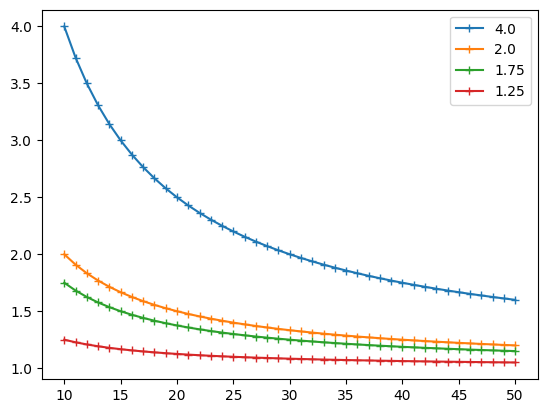

In [6]:
# Ilustramos cuatro funciones de decrecimiento basado en 1/x para los valores
# máximos de B = {4.0, 2.0, 1.75, 1.25}:
len_q_list = 10.0
max_win_len = 50
len_min = np.arange(len_q_list,max_win_len+1)
for B in [4.0, 2.0, 1.75, 1.25]:
    factor_win = 1.0+(B-1.0)*len_q_list/len_min
    plt.plot(len_min,factor_win,'+-',label=str(B));
plt.legend()

##  Clase _WindowScorer_

He aquí la definición de una clase _SmallestWindowScorer_ para implementar la técnica anterior. Se basa en la clase anterior _BM25Scorer_, ampliándola fundamentalmente con el método `get_boost_score`, que realiza el trabajo principal apoyándose a su vez en el método `min_sublist_with_all`. Éste último es el que en última instancia realiza la búsqueda efectiva de la ventana de texto más pequeña que contiene a todos los términos de la consulta:

In [7]:
class SmallestWindowScorer(BM25FScorer):
    def __init__(self, idf, query_dict, params, query_weight_scheme=None, doc_weight_scheme=None):
        super().__init__(idf, query_dict, params, query_weight_scheme=query_weight_scheme, doc_weight_scheme=doc_weight_scheme) #modified
        # Añadimos el parámetro "B" (máximo boosting alcanzable):
        self.B = params["B"]

    
    def min_sublist_with_all(self, A, B):
        """ Calcula el tamaño de la mínima sublista de B que contiene a toda la
            lista de términos de A.
        Args:
            A (lista de términos) : Lista de términos en la consulta.
            B (lista de términos) : Lista de términos en la que realizar la
                                    búsqueda de la sublista más pequeña.
        Return:
            min_length (dict) : La longitud de la sublista más pequeña encontrada
                                (float('inf') si no existe tal sublista).
        """
        # BEGIN YOUR CODE
        
        # Si A está vacía, no hay ventana que buscar
        if not A:
            return float('inf')
        
        # Si B está vacía, no podemos encontrar los términos de A
        if not B:
            return float('inf')
        
        # Convertir A a conjunto para verificar si todos los términos están presentes
        terms_needed = set(A)
        
        # Verificar si todos los términos de A están en B
        terms_in_B = set(B)
        if not terms_needed.issubset(terms_in_B):
            # Si falta algún término, no existe ventana válida
            return float('inf')
        
        # Algoritmo de ventana deslizante (sliding window)
        min_length = float('inf')
        left = 0
        term_count = {}  # Contador de términos en la ventana actual
        terms_found = 0  # Número de términos únicos de A encontrados en la ventana
        
        # Expandir la ventana moviendo el puntero derecho
        for right in range(len(B)):
            term = B[right]
            
            # Si el término está en A, actualizar contadores
            if term in terms_needed:
                if term not in term_count:
                    term_count[term] = 0
                term_count[term] += 1
                
                # Si es la primera vez que encontramos este término, incrementar contador
                if term_count[term] == 1:
                    terms_found += 1
            
            # Intentar contraer la ventana desde la izquierda
            while terms_found == len(terms_needed):
                # Actualizar la longitud mínima
                current_length = right - left + 1
                min_length = min(min_length, current_length)
                
                # Intentar mover el puntero izquierdo
                left_term = B[left]
                
                # Si el término izquierdo está en A, actualizar contadores
                if left_term in terms_needed:
                    term_count[left_term] -= 1
                    # Si ya no tenemos este término en la ventana, decrementar contador
                    if term_count[left_term] == 0:
                        terms_found -= 1
                
                left += 1
        
        ### END YOUR CODE
        # Devolvemos la longitud de la mínima sublista encontrada:
        return min_length
    

    def get_boost_score(self, q, d, debug=False):
        """ Calcula el factor de boost basado en la técnica 'smallest window'.
        Args:
            q (Query) : La consulta.
            d (Document) : El documento.
            debug (bool) : Flag para imprimir posible información de depuración.
        Return:
            factor_win (float) : Factor de boost, entre 1 y B.
        """

        # Lista de términos de la consulta de entrada:
        q_list = str(q).split()

        # Extraemos todas las listas de términos del documento, separadas
        # y procesadas debidamente según campos:
        all_lists = []
        try: # Campo url:
            d_url_list, _ = self.parse_url(d.url)
        except:
            d_url_list = []
        try: # Campo title:
            d_title_list = d.title.split()
        except:
            d_title_list = []
        try: # Campo headers:
            d_headers_lists = [h.split() for h in d.headers]
        except:
            d_headers_lists = []
        try: # Campo anchors:
            d_anchors_lists = [a.split() for a in d.anchors]
        except:
            d_anchors_lists = []
        try: # Campo body:
            # Construimos lista ficticia de términos a partir de body_hits,
            # rellenando con "-" donde no se conoce el término:
            max_pos = -1
            for k in d.body_hits.keys():
                max_pos_k = max(d.body_hits[k])
                if max_pos_k > max_pos:
                    max_pos = max_pos_k
            d_body_hits_list = (max_pos+1)*["-"]
            for k in d.body_hits.keys():
                for pos in d.body_hits[k]:
                    d_body_hits_list[pos] = k
        except:
            d_body_hits_list = []

        # Lista de todas las listas de términos a procesar para este documento:
        all_lists += [d_url_list] + [d_title_list] + d_headers_lists + d_anchors_lists + [d_body_hits_list]
        if debug:
            print(f"\nq_list: {q_list}")
            print("\nall_lists:")
            for l in all_lists:
                print(f" {l}")

        # Cómputo de la mínima ventana para todas las listas de todos los campos
        # (tamaño definitivo de la mínima ventana para este documento):
        if debug:
            print(f"\n Ternas (q_list, lista, min_dist):")
        len_min = float("inf")
        for i,lt in enumerate(all_lists):
            min_dist = self.min_sublist_with_all(q_list,lt)
            if debug:
               print(f"{q_list}     {lt}     {min_dist}")
            if min_dist < len_min:
                len_min = min_dist
        factor_win = 1.0+(self.B-1)*len(q_list)/len_min if len_min != float('inf') else 1.0
        return factor_win


    def get_net_score(self, q, d):
        """ Obtener el scoring neto para un par consulta - documento utilizando
            un factor de boosting computado usando la similaridad por la técnica
            del mínimo tamaño de ventana.
        Args:
            d (Document) : El documento.
            q (Query) : La consulta.

        Return:
            El scoring crudo multiplicado por el factor de boost.
        """
        boost = self.get_boost_score(q, d)
        raw_score = super().get_net_score(q, d)
        return boost * raw_score

Probamos en la celda siguiente la clase anterior. Definimos unos parámetros por defecto para la clase (incluyendo un $B$ máximo de 2.0), elegimos una consulta _q_ y un documento _d_ de prueba, y calculamos un factor de _boost_ en modo `debug=True`, para comprobar la corrección de los cómputos intermedios para calcularlo:

In [8]:
# Parámetros para la creación de la clase:
params_window = {
    "B": 2.0,
    "url_weight" : 1.0,
    "title_weight": 0.1,
    "body_hits_weight" : 0.25,
    "header_weight" : 0.5,
    "anchor_weight" : 0.3,
    "b_url" : 0.0,
    "b_title" : 0.0,
    "b_header" : 0.0,
    "b_body_hits" : 0.0,
    "b_anchor" : 0.0,
    "k1": 2.0,
    "pagerank_lambda" : 0.1,
    "pagerank_lambda_prime" : 1.0,
}

# Consulta y documento de prueba:
q = Query("stanford parking")
d = query_dict[q]["https://transportation.stanford.edu/"]

# Definición de instancia de la clase:
smallest_window_scorer = SmallestWindowScorer(theIDF, query_dict, params_window)

# Prueba de funcionamiento interno del método get_boost_score(...):
smallest_window_scorer.get_boost_score(q, d, debug=True)

# Prueba del método get_net_score(...) que calcula el scoring neto:
print(f"\nScoring neto tras usar el factor de boost: {smallest_window_scorer.get_net_score(q, d):5.3f}")


q_list: ['stanford', 'parking']

all_lists:
 ['https:', 'transportation', 'stanford', 'edu']
 ['stanford', 'parking', '&', 'transportation', 'services']
 ['stanford', 'university']
 ['parking', '&', 'transportation', 'services']
 ['parking', '&', 'transportation', 'news']
 ['getting', 'started', 'at', 'stanford']
 ['stanford', 'university']
 ['parking', '&', 'transportation']
 ['parking', 'and', 'transportation', 'services']
 ['parking', '&', 'transportation', 'services']
 ['http', 'transportation', 'stanford', 'edu']
 ['parking', 'and', 'transportation']
 ['transportation', 'stanford', 'edu']
 ['stanford', 'parking', '&', 'transportation', 'services']
 ['stanford', 'parking', '&', 'transportation', 'services', 'website']
 ['transportation', '&', 'parking', 'services']
 ['https', 'transportation', 'stanford', 'edu']
 ['parking', 'and', 'transportation', 'website']
 ['parking', '&', 'transportation', 'services', 'website']
 ['parking', 'on', 'campus']
 ['stanford', 'parking', '&', 'tra

# Ranking del dataset

## Clase _Rank_

Definimos una sencilla clase conteniendo sólo métodos de clase, que agrupa varias funciones de utilidad en la construcción de _rankings_ de documentos resultado de la búsqueda para una determinada consulta:

In [9]:
class Rank:
    # Sólo métodos de clase:
    def score(query_dict, score_type, idf, params):
        """ Llamar a esta función para puntuar (y ordenar según esta puntuación)
            todos los documentos correspondientes a una consulta, en un conjunto
            completo (dado en forma de mapping consultas -> {documentos}).
        Args:
            query_dict (dict) :  Mapeo Query->url->Document.
            score_type (str) : Tipo de scorer a usar ("baseline", "cosine", "bm25f", "window").
            idf (dict) : Diccionario IDF.
            params(dict) : Parámetros para el scorer usado.
        Return
            query_rankings (dict) : Un mapeo Query->Document->(r,s) (r=ranking=entero, comenzando en 1; s=score=float).
        """
        # Seleccionar subclase concreta de AbstractScorer para crear el tipo de instancia
        # concreta de scorer a utilizar:
        if score_type == "baseline": scorer = BaselineScorer(idf)
        elif score_type == "cosine": scorer = CosineSimilarityScorer(idf, query_dict, params)
        elif score_type == "bm25f": scorer = BM25FScorer(idf, query_dict, params)
        elif score_type == "window": scorer = SmallestWindowScorer(idf, query_dict, params)
        else: print('Tipo erróneo de scorer (debe ser "baseline", "cosine", "bm25f" o "window")!')

        # Diccionario donde se almacenará el mapping consultas->rankings devuelto:
        query_rankings = {} # query -> rank
        # Bucle que recorre todas las consultas en el diccionario de entrada:
        for i, query in enumerate(query_dict.keys()):
            q = query
            
            ### BEGIN YOUR CODE (FIXME)
            # Bucle que recorre todos los urls para cada consulta, obteniendo el score correspondiente:
            doc_scores = {}  # Diccionario temporal: Document -> score
            
            # Para cada documento de esta consulta, calcular su score
            for url in query_dict[q]:
                d = query_dict[q][url]
                score = scorer.get_net_score(q, d)
                doc_scores[d] = score
            
            # Ordenamos los documentos por sus scorings (de mayor a menor)
            sorted_docs = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)
            
            # ... y asignamos el mapeo Document->(ranking,score) resultante de todos los documentos
            # a la consulta correspondiente en el mapeo de salida Query->Document->ranking:
            query_rankings[q] = {}
            for rank, (doc, score) in enumerate(sorted_docs, start=1):
                query_rankings[q][doc] = (rank, score)
            
            ### END YOUR CODE (FIXME)

        return query_rankings

    def write_ranking_to_file(query_rankings, ranked_result_filename):
        """ Función que exporta los rankings obtenidos sobre un dataset de
           consultas-documentos a un fichero de texto.
        Args:
            query_rankings (dict) : Un mapeo Query->Document->ranking (ranking=entero, comenzando en 1).
            ranked_result_filename (str): Ruta al archivo de salida.
        """
        with open(ranked_result_filename, "w") as f:
            for query, docs in query_rankings.items():
                f.write("query: "+ query.__str__() + "\n")
                for doc, rank in docs.items():
                    output_info = "  url: " + doc.url + "\n" + \
                                  "    title: " + doc.title + "\n" + \
                                  "    rank:  " + str(rank[0]) + "\n" + \
                                  "    score: " + str(rank[1]) + "\n"
                    f.write(output_info)
        print(f"¡Escritura de archivo {ranked_result_filename} realizada!")

## Generación de archivos de rankings

Usando la clase `Rank` anterior, realizamos las ordenaciones de todas las consultas contenidas en `query_dict` (provenientes del archivo de _training_ inicial). Realizamos cuatro _rankings_ usando las cuatro técnicas desarrolladas (_"baseline"_, _"cosine"_, _"bm25f"_, _"window"_), guardando cada una de ellas en el correspondiente archivo `output/ranked_train_{tecnica}.txt`:

In [12]:
# Definir parámetros para el scorer CosineSimilarity
params_cosine = {
    "url_weight" : 10,
    "title_weight": 0.1,
    "body_hits_weight" : 0.1,
    "header_weight" : 0.1,
    "anchor_weight" : 0.1,
    "smoothing_body_length" : 500,
}

for method, params in zip(["baseline", "cosine", "bm25f", "window"], [None, params_cosine, params_bm25f, params_window]):
    query_dict = load_train_data(os.path.join(data_dir, "pa3.signal.train"))
    query_rankings = Rank.score(query_dict, method, theIDF, params)
    Rank.write_ranking_to_file(query_rankings, os.path.join("output", "ranked_train_"+method+".txt"))
    print(f"Rankings realizados para {len(query_rankings)} consultas, (usando el {method} scorer)\n")

¡Escritura de archivo output/ranked_train_baseline.txt realizada!
Rankings realizados para 731 consultas, (usando el baseline scorer)

¡Escritura de archivo output/ranked_train_cosine.txt realizada!
Rankings realizados para 731 consultas, (usando el cosine scorer)

¡Escritura de archivo output/ranked_train_bm25f.txt realizada!
Rankings realizados para 731 consultas, (usando el bm25f scorer)

¡Escritura de archivo output/ranked_train_window.txt realizada!
Rankings realizados para 731 consultas, (usando el window scorer)



A título de ejemplo de los resultados obtenidos, a continuación mostramos los _rankings_ realizados por los cuatro métodos para los diez documentos obtenidos para la primera consulta del _dataset_ de _training_:

In [13]:
!echo RANKING 1ª CONSULTA, BASELINE:
!head -41 output/ranked_train_baseline.txt
!echo

!echo RANKING 1ª CONSULTA, COSINE:
!head -41 output/ranked_train_cosine.txt
!echo

!echo RANKING 1ª CONSULTA, BM25F:
!head -41 output/ranked_train_bm25f.txt
!echo

!echo RANKING 1ª CONSULTA, WINDOW:
!head -41 output/ranked_train_window.txt
!echo


RANKING 1ª CONSULTA, BASELINE:
query: stanford aoerc pool hours
  url: http://web.stanford.edu/group/masters/pool.html
    title: stanford masters swimming pool & parking information
    rank:  1
    score: 2
  url: https://cardinalrec.stanford.edu/facilities/aoerc/
    title: 
    rank:  2
    score: 2
  url: https://glo.stanford.edu/events/stanford-rec-open-house
    title: stanford rec open house graduate life office
    rank:  3
    score: 2
  url: http://events.stanford.edu/2014/February/18/
    title: events at stanford tuesday february 18 2014
    rank:  4
    score: 1
  url: http://events.stanford.edu/2014/February/6/
    title: events at stanford thursday february 6 2014
    rank:  5
    score: 1
  url: http://events.stanford.edu/2014/March/13/
    title: events at stanford thursday march 13 2014
    rank:  6
    score: 1
  url: http://events.stanford.edu/2014/March/3/
    title: events at stanford monday march 3 2014
    rank:  7
    score: 1
  url: http://med.stanford.edu/co